# Edgotyping Data Analyses

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.optimize import minimize_scalar
from scipy.signal import find_peaks
# from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')
# Set style
# plt.style.use('seaborn-v0_8')
sns.set_style(style='white')
sns.set_palette("husl")
%matplotlib inline

sys.path.append("../..")
from utils import *

## 1. Loading data

### 1.1 VarChAMP PPI dataset

In [2]:
edgotyping_scores_df = pl.read_excel("../1_inputs/VarChAMP1percentEdgotypingScores_SeqConfirmed_ONLY.xlsx")
edgotyping_scores_df

ad_orf_id,ad_mut_id,db_orf_id,db_mut_id,condition_name,retest_batch,media_control,consensus_score,ad_symbol,symbol,aa_change,nt_change,ensembl_gene_id,collection,clinvar_clnsig_clean,gnomad_af,StarStatus,allele_0,final_score,final_score_wt,edgotype,edgotype_wt_2,seq_confirmation,seq_confirmation_wt,db_node_seq_confirmation,combo SWIM+pool,POOL only,SWIM only
i64,i64,i64,i64,str,str,bool,i64,str,str,str,str,str,str,str,f64,i64,str,i64,i64,str,str,i64,i64,i64,bool,bool,bool
145,0,145,200059,"""LWH1""","""VUSAPWT1B2""",false,2,"""PTS""","""PTS""","""Arg25Gln""","""74G>A""","""ENSG00000150787""","""CEGS2""","""1_Pathogenic""",6.9900e-7,2,"""PTS_Arg25Gln""",2,3,"""inconclusive""","""inconclusive""",1,1,1,true,true,true
145,0,145,200065,"""LWH1""","""VUSAPWT1B2""",false,2,"""PTS""","""PTS""","""Asp116Gly""","""347A>G""","""ENSG00000150787""","""CEGS2""","""3_Conflicting""",0.000004,1,"""PTS_Asp116Gly""",2,3,"""inconclusive""","""inconclusive""",1,1,1,true,true,true
152,0,5066,201830,"""LWH1""","""VUSAPWT1B2""",false,3,"""TRIM27""","""BAG3""","""Arg258Trp""","""772C>T""","""ENSG00000151929""","""CEGS2""","""2_Benign""",0.0004399,2,"""BAG3_Arg258Trp""",3,3,"""not perturbed""","""not perturbed""",1,1,1,true,true,true
152,0,5066,201831,"""LWH1""","""VUSAPWT1B2""",false,0,"""TRIM27""","""BAG3""","""Leu462Pro""","""1385T>C""","""ENSG00000151929""","""CEGS2""","""1_Pathogenic""",null,1,"""BAG3_Leu462Pro""",0,3,"""perturbed""","""perturbed""",1,1,2,true,true,true
152,0,5066,201832,"""LWH1""","""VUSAPWT1B2""",false,2,"""TRIM27""","""BAG3""","""Pro380Ser""","""1138C>T""","""ENSG00000151929""","""CEGS2""","""2_Benign""",0.000499,2,"""BAG3_Pro380Ser""",2,3,"""inconclusive""","""inconclusive""",1,1,1,true,true,true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
100080183,0,71191,205704,"""LWH1""","""VUSAPWT6B1""",false,4,"""MEIS3""","""SUOX""","""Ala265Asp""","""794C>A""","""ENSG00000139531""","""CEGS2""","""4_VUS""",0.000042,1,"""SUOX_Ala265Asp""",4,4,"""not perturbed""","""not perturbed""",1,1,1,true,true,true
100080183,0,71191,205705,"""LWH1""","""VUSAPWT6B1""",false,4,"""MEIS3""","""SUOX""","""Gly530Asp""","""1589G>A""","""ENSG00000139531""","""CEGS2""","""1_Pathogenic""",6.8412e-7,null,"""SUOX_Gly530Asp""",4,4,"""not perturbed""","""not perturbed""",1,1,2,true,true,true
100080871,0,5066,201830,"""LWH1""","""VUSAPWT1B2""",false,4,"""PRDM6""","""BAG3""","""Arg258Trp""","""772C>T""","""ENSG00000151929""","""CEGS2""","""2_Benign""",0.0004399,2,"""BAG3_Arg258Trp""",4,3,"""inconclusive""","""inconclusive""",1,1,1,true,true,true


#### Filtering for Pass-QC edgotyping data

In [3]:
seq_confirm_res_df = pl.read_csv(f"../../../1_allele_collection/3_outputs/varchamp_bms_allele_collection.tsv", 
                                 separator="\t", infer_schema_length=1000000)

edgotyping_scores_df = edgotyping_scores_df.join(
    seq_confirm_res_df.filter(
        pl.col("db_seq_final")=="Y"
    ).unique("gene_variant"),
    left_on=["db_orf_id","db_mut_id"],
    right_on=["orf_id","mut_id"],
    how="inner"
)

edgotyping_scores_df.shape

(2793, 901)

### 1.2 Pillar Project CAVA PPI dataset

In [4]:
edgotyping_scores_alleles_df = pl.read_excel("../1_inputs/VarChampPillarEdgotypingScoresWithAlleleInfo_ToShare.xlsx")
edgotyping_scores_alleles_df#["seq_confirmed_final"].unique()

id,category,symbol,ccsb_mutation_id,ccsb_allele_id,db_orf_id,cv_allele_id,spdi,clinical_significance_simple,nt_change,aa_change,ensembl_protein_id,aa_change_ensp,ad_orf_id,ad_symbol,standard_batch,retest_pla,retest_pla_full,retest_pos,final_score,final_score_wt,final_score_wt_huri,edgotype,edgotype_wt_2,seq_confirmed_wt_ppi,seq_confirmed_allele_ppi,seq_confirmed_final
i64,str,str,str,str,i64,i64,str,str,str,str,str,str,i64,str,str,i64,str,str,str,i64,i64,str,str,i64,i64,i64
1,"""CAVA""","""CTCF""","""CCSBVarC010816""","""ALE00008908""",6173,208297,"""NC_000016.10:67636779:C:T""","""benign""","""1927C>T""","""Pro643Ser""","""ENSP00000264010.4""","""ENSP00000264010.4:p.Pro643Ser""",9637,"""TRAF2""","""HsVCplarAs1""",1,"""HsVCplarAs1_001""","""F09""","""2""",2,4,"""NA""","""not perturbed""",1,1,1
2,"""CAVA""","""CTCF""","""CCSBVarC010858""","""ALE00014571""",6173,799962,"""NC_000016.10:67626562:C:G""","""Pathogenic""","""1365C>G""","""His455Gln""","""ENSP00000264010.4""","""ENSP00000264010.4:p.His455Gln""",9637,"""TRAF2""","""HsVCplarAs1""",1,"""HsVCplarAs1_001""","""H09""","""2""",2,4,"""NA""","""not perturbed""",1,1,1
3,"""CAVA""","""CTCF""","""CCSBVarC010870""","""ALE00013232""",6173,260121,"""NC_000016.10:67621454:A:G""","""Pathogenic""","""1220A>G""","""Tyr407Cys""","""ENSP00000264010.4""","""ENSP00000264010.4:p.Tyr407Cys""",9637,"""TRAF2""","""HsVCplarAs1""",1,"""HsVCplarAs1_001""","""A10""","""2""",2,4,"""NA""","""not perturbed""",1,1,1
4,"""CAVA""","""CTCF""","""CCSBVarC010851""","""ALE00013946""",6173,422102,"""NC_000016.10:67616816:C:T""","""Pathogenic""","""1024C>T""","""Arg342Cys""","""ENSP00000264010.4""","""ENSP00000264010.4:p.Arg342Cys""",9637,"""TRAF2""","""HsVCplarAs1""",1,"""HsVCplarAs1_001""","""G09""","""AA""",2,4,"""NA""","""NA""",1,1,1
6,"""CAVA""","""CTCF""","""CCSBVarC010816""","""ALE00008908""",6173,208297,"""NC_000016.10:67636779:C:T""","""benign""","""1927C>T""","""Pro643Ser""","""ENSP00000264010.4""","""ENSP00000264010.4:p.Pro643Ser""",9016,"""ZMYM6""","""HsVCplarAs6""",1,"""HsVCplarAs6_001""","""C01""","""2""",2,1,"""NA""","""not perturbed""",1,1,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11163,"""CAVA""","""RAF1""","""CCSBVarC008858""","""ALE00013778""",732,496336,"""NC_000003.12:12604195:A:C""","""Pathogenic""","""775T>G""","""Ser259Ala""","""ENSP00000251849.4""","""ENSP00000251849.4:p.Ser259Ala""",5462,"""NRAS""","""HsVCplarAs6""",25,"""HsVCplarAs6_025""","""B02""","""NULL""",null,0,"""NULL""","""NULL""",1,1,1
11164,"""CAVA""","""RAF1""","""CCSBVarC008860""","""ALE00011641""",732,28999,"""NC_000003.12:12584624:G:C""","""Pathogenic""","""1837C>G""","""Leu613Val""","""ENSP00000251849.4""","""ENSP00000251849.4:p.Leu613Val""",5462,"""NRAS""","""HsVCplarAs6""",25,"""HsVCplarAs6_025""","""C02""","""NULL""",null,0,"""NULL""","""NULL""",1,1,1
11165,"""CAVA""","""RAF1""","""CCSBVarC008862""","""ALE00012143""",732,49083,"""NC_000003.12:12599717:C:G""","""Pathogenic""","""1082G>C""","""Gly361Ala""","""ENSP00000251849.4""","""ENSP00000251849.4:p.Gly361Ala""",5462,"""NRAS""","""HsVCplarAs6""",25,"""HsVCplarAs6_025""","""D02""","""NULL""",null,0,"""NULL""","""NULL""",1,1,1


In [5]:
# edgotyping_scores_alleles_df.filter(pl.col("symbol")=="RAD51D").sort("aa_change")
# edgotyping_scores_alleles_df.sort(["symbol","aa_change"])
# edgotyping_scores_alleles_df.unique(subset=["id","db_orf_id"])

#### Store the alleles from CAVA PPI dataset for allele collection

In [6]:
# edgotyping_cava_df = edgotyping_scores_alleles_df.select(
#     pl.col(["symbol","ccsb_mutation_id","ccsb_allele_id",
#             "spdi","nt_change","aa_change","category","seq_confirmed_wt_ppi",
#             "seq_confirmed_allele_ppi","seq_confirmed_final"])
# ).rename({"category": "collection"}).unique(["spdi","ccsb_mutation_id"])
# # edgotyping_cava_df.write_csv("../../../1_allele_collection/1_inputs/Edgotyping_CAVA_alleles.csv")

### 1.3 Combine two datasets

In [7]:
overlapped_cols = set(edgotyping_scores_df.columns).intersection(set(edgotyping_scores_alleles_df.columns))
combined_df = pl.concat([
    edgotyping_scores_df.select(pl.col(overlapped_cols)),
    edgotyping_scores_alleles_df.select(pl.col(overlapped_cols))
], how="vertical_relaxed").with_columns(
    pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_variant")
)
print("Unique variants profiled:", combined_df.unique(subset="gene_variant"))
display(combined_df)

Unique variants profiled: shape: (963, 17)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ccsb_muta ┆ edgotype_ ┆ final_sco ┆ edgotype  ┆ … ┆ seq_confi ┆ ccsb_alle ┆ ad_symbol ┆ gene_var │
│ tion_id   ┆ wt_2      ┆ re_wt     ┆ ---       ┆   ┆ rmed_alle ┆ le_id     ┆ ---       ┆ iant     │
│ ---       ┆ ---       ┆ ---       ┆ str       ┆   ┆ le_ppi    ┆ ---       ┆ str       ┆ ---      │
│ str       ┆ str       ┆ i64       ┆           ┆   ┆ ---       ┆ str       ┆           ┆ str      │
│           ┆           ┆           ┆           ┆   ┆ i64       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ CCSBVarC0 ┆ perturbed ┆ 3         ┆ perturbed ┆ … ┆ null      ┆ ALE000012 ┆ TRIM38    ┆ STXBP1_G │
│ 01222     ┆           ┆           ┆           ┆   ┆           ┆ 22        ┆           ┆ ly544Asp │
│ CCSBVarC0 ┆ not       ┆ 2         ┆ NA        

ccsb_mutation_id,edgotype_wt_2,final_score_wt,edgotype,nt_change,ad_orf_id,aa_change,seq_confirmed_wt_ppi,symbol,final_score,seq_confirmed_final,db_orf_id,spdi,seq_confirmed_allele_ppi,ccsb_allele_id,ad_symbol,gene_variant
str,str,i64,str,str,i64,str,i64,str,str,i64,i64,str,i64,str,str,str
"""CCSBVarC003145""","""NA""",0,"""NA""","""899A>T""",56717,"""Asp300Val""",null,"""ITGB2""",null,null,4765,"""NC_000021.9:44899161:T:A""",null,"""ALE00003145""","""KRTAP10-8""","""ITGB2_Asp300Val"""
"""CCSBVarC002944""","""NA""",null,"""NA""","""508A>G""",8359,"""Ile170Val""",null,"""SMAD3""","""4""",null,11805,"""NC_000015.10:67165360:A:G""",null,"""ALE00002944""","""CCDC33""","""SMAD3_Ile170Val"""
"""CCSBVarC002944""","""NA""",null,"""NA""","""508A>G""",71704,"""Ile170Val""",null,"""SMAD3""","""4""",null,11805,"""NC_000015.10:67165360:A:G""",null,"""ALE00002944""","""SMURF2""","""SMAD3_Ile170Val"""
"""CCSBVarC007935""","""not perturbed""",3,"""not perturbed""","""388G>A""",439,"""Gly130Ser""",null,"""LITAF""","""3""",null,52920,"""NC_000016.10:11549735:C:T""",null,"""ALE00007921""","""RNF208""","""LITAF_Gly130Ser"""
"""CCSBVarC007935""","""not perturbed""",3,"""not perturbed""","""388G>A""",730,"""Gly130Ser""",null,"""LITAF""","""3""",null,52920,"""NC_000016.10:11549735:C:T""",null,"""ALE00007921""","""HPCAL1""","""LITAF_Gly130Ser"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""CCSBVarC008858""","""NULL""",null,"""NULL""","""775T>G""",5462,"""Ser259Ala""",1,"""RAF1""","""NULL""",1,732,"""NC_000003.12:12604195:A:C""",1,"""ALE00013778""","""NRAS""","""RAF1_Ser259Ala"""
"""CCSBVarC008860""","""NULL""",null,"""NULL""","""1837C>G""",5462,"""Leu613Val""",1,"""RAF1""","""NULL""",1,732,"""NC_000003.12:12584624:G:C""",1,"""ALE00011641""","""NRAS""","""RAF1_Leu613Val"""
"""CCSBVarC008862""","""NULL""",null,"""NULL""","""1082G>C""",5462,"""Gly361Ala""",1,"""RAF1""","""NULL""",1,732,"""NC_000003.12:12599717:C:G""",1,"""ALE00012143""","""NRAS""","""RAF1_Gly361Ala"""


#### Drop the null edges

In [8]:
edgotyping_scores_final = combined_df.with_columns(
    pl.col("edgotype_wt_2").replace(["NA", "NULL"], [None, None]).alias("edgotype_wt_final")
).drop_nulls(subset="edgotype_wt_final")
print("Unique variants with edgotyping data:", edgotyping_scores_final.unique(subset="gene_variant"))

Unique variants with edgotyping data: shape: (832, 18)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ccsb_muta ┆ edgotype_ ┆ final_sco ┆ edgotype  ┆ … ┆ ccsb_alle ┆ ad_symbol ┆ gene_vari ┆ edgotype │
│ tion_id   ┆ wt_2      ┆ re_wt     ┆ ---       ┆   ┆ le_id     ┆ ---       ┆ ant       ┆ _wt_fina │
│ ---       ┆ ---       ┆ ---       ┆ str       ┆   ┆ ---       ┆ str       ┆ ---       ┆ l        │
│ str       ┆ str       ┆ i64       ┆           ┆   ┆ str       ┆           ┆ str       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ CCSBVarC0 ┆ not       ┆ 2         ┆ NA        ┆ … ┆ ALE000172 ┆ RUFY3     ┆ CAPN3_Asp ┆ not pert │
│ 17246     ┆ perturbed ┆           ┆           ┆   ┆ 01        ┆           ┆ 195Gly    ┆ urbed    │
│ CCSBVarC0 ┆ not       ┆ 3         

In [9]:
# edgotyping_scores_final.filter(
#     pl.col("gene_variant").is_in(
#         {'RAD51D_Ala231Ser',
#          'RAD51D_Cys9Ser',
#          'RAD51D_Glu307Lys',
#          'RAD51D_Gly289Ser',
#          'RAD51D_His23Arg',
#          'RAD51D_Ile251Val',
#          'RAD51D_Met308Val',
#          'RAD51D_Phe305Leu',
#          'RAD51D_Thr328Ile',
#          'RAD51D_Val132Ile',
#          'RAD51D_Val28Leu',
#          'RAD51D_Val56Gly',
#          'RAD51D_Val66Leu',
#          'RAD51D_Val66Met'}
#     )
# ).sort("gene_variant")

In [10]:
variant_ppi_perturb_stats = (
    edgotyping_scores_final
    .group_by("gene_variant")
    .agg([
        # Total occurrences per gene_variant
        pl.len().alias("total_occurrences"),
        # Count each edgotype category
        pl.col("edgotype_wt_final").filter(pl.col("edgotype_wt_final") == "not perturbed").len().alias("not_perturbed_count"),
        pl.col("edgotype_wt_final").filter(pl.col("edgotype_wt_final") == "inconclusive").len().alias("inconclusive_count"),
        pl.col("edgotype_wt_final").filter(pl.col("edgotype_wt_final") == "perturbed").len().alias("perturbed_count"),
    ])
    .with_columns([
        # Calculate percentages
        (pl.col("not_perturbed_count") / pl.col("total_occurrences") * 100).round(2).alias("not_perturbed_percentage"),
        (pl.col("inconclusive_count") / pl.col("total_occurrences") * 100).round(2).alias("inconclusive_percentage"),
        (pl.col("perturbed_count") / pl.col("total_occurrences") * 100).round(2).alias("perturbed_percentage")
    ]).with_columns(
        (100 - pl.col("perturbed_percentage")).alias("no_perturbed_percentage"),
        (pl.col("total_occurrences") - pl.col("perturbed_count")).alias("no_perturbed_count"),
        (pl.col("perturbed_percentage") * pl.col("total_occurrences") / 100).alias("edge_x_pt_perc")
    )
    .sort("gene_variant")
)
print(variant_ppi_perturb_stats)

shape: (832, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ gene_vari ┆ total_occ ┆ not_pertu ┆ inconclus ┆ … ┆ perturbed ┆ no_pertur ┆ no_pertur ┆ edge_x_p │
│ ant       ┆ urrences  ┆ rbed_coun ┆ ive_count ┆   ┆ _percenta ┆ bed_perce ┆ bed_count ┆ t_perc   │
│ ---       ┆ ---       ┆ t         ┆ ---       ┆   ┆ ge        ┆ ntage     ┆ ---       ┆ ---      │
│ str       ┆ u32       ┆ ---       ┆ u32       ┆   ┆ ---       ┆ ---       ┆ u32       ┆ f64      │
│           ┆           ┆ u32       ┆           ┆   ┆ f64       ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ ACSF3_Arg ┆ 3         ┆ 0         ┆ 0         ┆ … ┆ 100.0     ┆ 0.0       ┆ 0         ┆ 3.0      │
│ 10Trp     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ACSF3_Arg ┆ 3         ┆ 0         ┆ 0         ┆ … ┆ 100.0     ┆ 0.0     

In [11]:
# variant_ppi_perturb_stats.filter(pl.col("gene_variant").str.contains("RAD51D"))

## 2. ClinVar Analysis

In [12]:
# # process metadata
# # append metadata and write out files
# metadata = pl.read_csv(f"../../../1_allele_collection/3_outputs/varchamp_alleles_with_pillar_annotations.tsv", 
#                        separator="\t", infer_schema_length=1000000)
# # mut_cols = ["mutation_id_rc4", "mutation_id_cegs2", "mutation_id_edgotyping3"]
# # id_vars = [col for col in metadata.columns if col not in mut_cols]
# # metadata = metadata.unpivot(index=id_vars, 
# #                             on=mut_cols,
# #                             variable_name="mutation_collection",
# #                             value_name="mut_id")

# priority_col = ["orf_id", "mut_id", "symbol", "aa_change", "gene_variant", "ensembl_gene_id", "clinvar_clnsig_clean", "gnomad_af", "StarStatus"]
# # metadata = metadata.select(priority_col).filter(~pl.col("mut_id").is_null()).with_columns(
# #     pl.col("mut_id").cast(pl.Int64).alias("mut_id"),
# #     pl.col("orf_id").cast(pl.Int64).alias("orf_id"),
# #     pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_variant")
# # )
# # metadata

In [13]:
variant_ppi_perturb_stats_clinvar = variant_ppi_perturb_stats.with_columns(
    pl.lit(True).alias("ppi_assayed")
).join(
    seq_confirm_res_df.select(pl.col(["gene_variant"]+[c for c in seq_confirm_res_df.columns if c not in variant_ppi_perturb_stats.columns])), 
    on=["gene_variant"],
    how="left"
).unique("gene_variant")
variant_ppi_perturb_stats_clinvar

gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,no_perturbed_percentage,no_perturbed_count,edge_x_pt_perc,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,…,protein_00001053-a-1 avg,protein_00001053-a-1 outliers⁺⁺,protein_00001032-a-1 avg,protein_00001032-a-1 outliers⁺⁺,protein_00001033-a-1 avg,protein_00001033-a-1 outliers⁺⁺,protein_00001034-a-1 avg,protein_00001034-a-1 outliers⁺⁺,protein_00000959-a-1 avg,protein_00000959-a-1 outliers⁺⁺,protein_00001177-a-1 avg,protein_00001177-a-1 outliers⁺⁺,protein_00000001-d-2 avg,protein_00000001-d-2 outliers⁺⁺,protein_00000966-a-1 avg,protein_00000966-a-1 outliers⁺⁺,protein_00000013-a-1 avg,protein_00000013-a-1 outliers⁺⁺,protein_00000101-a-1 avg,protein_00000101-a-1 outliers⁺⁺,protein_00000102-0-1 avg,protein_00000102-0-1 outliers⁺⁺,protein_00000745-a-1 avg,protein_00000745-a-1 outliers⁺⁺,protein_00000746-a-1 avg,protein_00000746-a-1 outliers⁺⁺,protein_00001065-a-1 avg,protein_00001065-a-1 outliers⁺⁺,protein_00000686-a-1 avg,protein_00000686-a-1 outliers⁺⁺,protein_00001112-a-1 avg,protein_00001112-a-1 outliers⁺⁺,seq_confirmed_wt_ppi,seq_confirmed_allele_ppi,seq_confirmed_final,chr,chr_pos_38
str,u32,u32,u32,u32,f64,f64,f64,f64,u32,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,f64,f64,…,f64,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,str,str,f64,str,i64,i64,i64,str,i64
"""CRYAB_Gly154Ser""",1,1,0,0,100.0,0.0,0.0,100.0,1,0.0,true,"""CRYAB""","""ENSG00000109846""",5585,215440,"""CCSBVarC006122""","""ALE00006122""","""NC_000011.10:111908832:C:T""","""460G>A""","""Gly154Ser""","""CEGS2""","""CegsMutGDEh1033""","""H07""","""GDEhDisVCh_40077""","""A05""",1.0,"""CegsMutGDDh1033""","""H07""","""VUSN2Hmut_GDN2h_06""","""A05""","""VUSMutpDEST2_05""","""D03""","""VUSmut_GDEh06""","""A05""",1.0,1.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""CAPN3_Asp195Gly""",2,2,0,0,100.0,0.0,0.0,100.0,2,0.0,true,"""CAPN3""",null,null,null,"""CCSBVarC017246""","""ALE00017201""","""NC_000015.10:42410432:A:G""","""584A>G""","""Asp195Gly""","""Lacoste""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,1,1,null,null
"""MVK_Leu255Pro""",1,0,0,1,0.0,0.0,100.0,0.0,0,1.0,true,"""MVK""","""ENSG00000110921""",281,18,"""CCSBVarC007125""","""ALE00007123""","""NC_000012.12:109590857:T:C""","""764T>C""","""Leu255Pro""","""Edgotyping3""","""VUSMutGDEh010""","""A01""","""GDEhDisVCh_40020""","""C07""",2.0,"""VUSMutGDDh010""","""A01""","""VUSN2Hmut_GDN2h_03""","""B05""","""VUSMutpDEST2_01""","""G02""","""VUSmut_GDEh03""","""B05""",1.0,1.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""SMARCB1_Pro48Leu""",1,0,0,1,0.0,0.0,100.0,0.0,0,1.0,true,"""SMARCB1""","""ENSG00000099956""",53965,204888,"""CCSBVarC005063""","""ALE00005063""","""NC_000022.11:23791805:C:T""","""143C>T""","""Pro48Leu""","""CEGS2""","""CegsMutGDEh1032""","""G06""","""GDEhDisVCh_40081""","""B04""",1.0,"""CegsMutGDDh1032""","""G06""","""VUSN2Hmut_GDN2h_05""","""F12""","""VUSMutpDEST2_12""","""C04""","""VUSmut_GDEh05""","""F12""",1.0,1.0,…,null,null,null,null,null,null,null,nul

In [20]:
# variant_ppi_perturb_stats_clinvar.filter(
#     pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic", "2_Benign"])
# ).with_columns(
#     pl.when(pl.col("clinvar_clnsig_clean")=="1_Pathogenic")
#     .then(pl.lit("Positive"))
#     .otherwise(pl.lit("Negative"))
#     .alias("referenceSet"),
#     pl.col("perturbed_percentage").alias("score"),
#     pl.col("gene_variant").alias("hgvsp")
# ).select(
#     pl.col(["hgvsp", "score", "referenceSet", "perturbed_percentage", "gene_variant", "clinvar_clnsig_clean"])
# ).write_csv("../3_outputs/PPI_referenceSet.csv")

# variant_ppi_perturb_stats_clinvar.with_columns(
#     pl.col("perturbed_percentage").alias("score"),
#     pl.col("gene_variant").alias("hgvs_pro")
# ).select(pl.col(["hgvs_pro", "score"])).write_csv("../3_outputs/PPI_allScores.csv")

In [14]:
%%bash
source ~/software/anaconda3/etc/profile.d/conda.sh
conda activate py310
Rscript ../../threshold_calibration/calcLLR.R ../3_outputs/PPI_allScores.csv ../3_outputs/PPI_referenceSet.csv --outfile "../3_outputs/calcLLR/PPI_LLR_score_bcv" --logfile "../3_outputs/calcLLR/PPI_LLR_bcv.log" --bandwidth "bcv" --printTransitions #--outlierSuppression 0.2
# Rscript ../../threshold_calibration/calcLLR.R ../3_outputs/PPI_allScores.csv ../3_outputs/PPI_referenceSet.csv --outfile "../3_outputs/calcLLR/PPI_LLR_score_nrd0" --logfile "../3_outputs/calcLLR/PPI_LLR_nrd0.log" --bandwidth "nrd0" --printTransitions #--outlierSuppression 0.1

## Non-smooth, failed bandwidth:
## No need to run any more
# Rscript ../../threshold_calibration/calcLLR.R ../3_outputs/DUALIPA_allScores.csv ../3_outputs/DUALIPA_referenceSet.csv --outfile "../3_outputs/calcLLR/DUALIPA_LLR_score_default" --logfile "../3_outputs/calcLLR/DUALIPA_LLR_default.log" --printTransitions
# Rscript ../../threshold_calibration/calcLLR.R ../3_outputs/DUALIPA_allScores.csv ../3_outputs/DUALIPA_referenceSet.csv --outfile "../3_outputs/calcLLR/DUALIPA_LLR_score_nrd" --logfile "../3_outputs/calcLLR/DUALIPA_LLR_nrd.log" --bandwidth "nrd" --printTransitions
# Rscript ../../threshold_calibration/calcLLR.R ../3_outputs/DUALIPA_allScores.csv ../3_outputs/DUALIPA_referenceSet.csv --outfile "../3_outputs/calcLLR/DUALIPA_LLR_score_sj" --logfile "../3_outputs/calcLLR/DUALIPA_LLR_sj.log" --printTransitions --bandwidth "SJ"
# Rscript ../../threshold_calibration/calcLLR.R ../3_outputs/DUALIPA_allScores.csv ../3_outputs/DUALIPA_referenceSet.csv --outfile "../3_outputs/calcLLR/DUALIPA_LLR_score_nrd" --logfile "../3_outputs/calcLLR/DUALIPA_LLR_nrd.log" --bandwidth "nrd" --printTransitions

Loading required package: parallel
Loading required package: maveLLR
Warning message:
NAs introduced by coercion 


2025-08-13_01:58:17 INFO: Reading input 
2025-08-13_01:58:17 INFO: Calculating densties 


Warning messages:
1: In stats::bw.bcv(data) : minimum occurred at one end of the range
2: In stats::bw.bcv(data) : minimum occurred at one end of the range
3: In stats::bw.bcv(data) : minimum occurred at one end of the range
4: In stats::bw.bcv(data) : minimum occurred at one end of the range


2025-08-13_01:58:18 INFO: Drawing LLR plot 
2025-08-13_01:58:18 INFO: Drawing PRC curve 
  |======================================================================| 100%2025-08-13_01:58:18 INFO: Category transitions:  
63.163 : none -> patho.support
2025-08-13_01:58:18 INFO: Bootstrapping confidence intervals at  10000  iterations 
2025-08-13_01:58:18 INFO: Writing output to file  ../3_outputs/calcLLR/PPI_LLR_score_bcv.csv 
2025-08-13_01:58:18 INFO: Done! 


In [43]:
thres_manual, thres_llr = 75, 63.163
variant_ppi_perturb_stats_clinvar = variant_ppi_perturb_stats_clinvar.with_columns(
    (pl.when(pl.col("perturbed_percentage")>=thres_manual)
     .then(pl.lit(True))
     .otherwise(pl.lit(False))
    ).alias("ppi_perturbed_manual"),
    (pl.when(pl.col("perturbed_percentage")>=thres_llr)
     .then(pl.lit(True))
     .otherwise(pl.lit(False))
    ).alias("ppi_perturbed_llr"),
    pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others")
)

In [16]:
# variant_ppi_perturb_stats_clinvar.write_csv("../3_outputs/edgotyping_final_combined_scores.csv")
# variant_ppi_perturb_stats_clinvar.write_csv("../../../3_integrated_assay_analyses/1_inputs/ppi/edgotyping_perturb_sum_stats.csv")

## 3. Plot Statistics

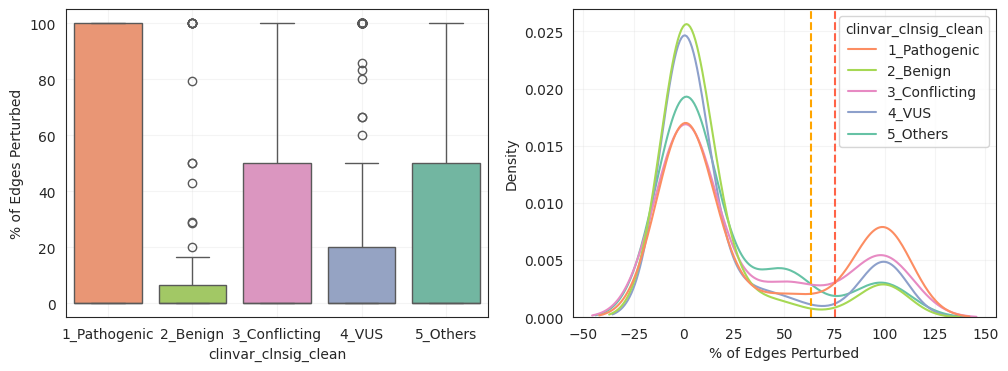

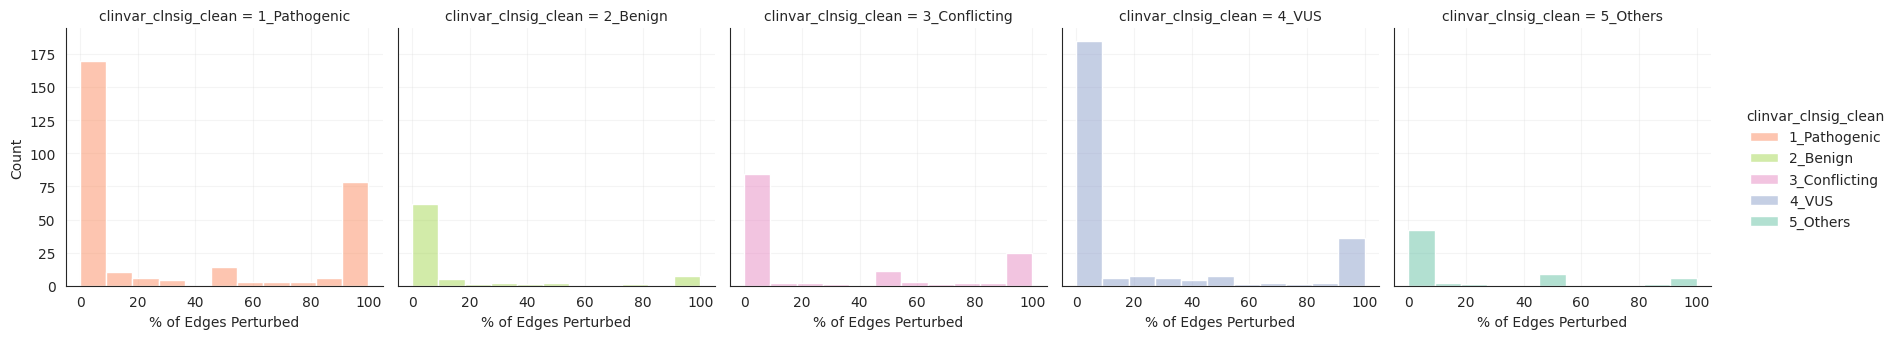

In [44]:
# edgotyping_clinvar_sum = (
#     variant_ppi_perturb_stats_clinvar
#       .group_by(["clinvar_clnsig_clean", "edgotype_wt_final"])
#       .len()
#       .sort(by="clinvar_clnsig_clean")
#       .rename({"len": "count"})
# ).with_columns(
#     pl.col("clinvar_clnsig_clean").fill_null("6_NoClinVar")
# ).to_pandas()

# # Compute the total count PER clinvar_clnsig_clean (as a Series aligned to df.index):
# totals = edgotyping_clinvar_sum.groupby("clinvar_clnsig_clean")["count"].transform("sum")
# # Now compute percentage = count ÷ total_for_that_clinvar × 100
# edgotyping_clinvar_sum["percentage"] = edgotyping_clinvar_sum["count"] / totals * 100

fig, ax = plt.subplots(1,2, figsize=(12, 4))
sns.boxplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
                 x="clinvar_clnsig_clean", y="perturbed_percentage", ax=ax[0],#hue="clinvar_clnsig_clean",
                 palette=palette_dict["clinvar_clnsig_clean"],
              # flier_kws=dict(facecolor=".2", linewidth=.9, marker="^"),
             ) # hue_order=["perturbed","not perturbed","inconclusive"]
# sns.violinplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="clinvar_clnsig_clean", y="perturbed_percentage", ax=ax[0],#hue="clinvar_clnsig_clean",
#                  palette=palette_dict["clinvar_clnsig_clean"],
#               # flier_kws=dict(facecolor=".2", linewidth=.9, marker="^"),
#              ) # hue_order=["perturbed","not perturbed","inconclusive"]
sns.kdeplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
                 x="perturbed_percentage", hue="clinvar_clnsig_clean", common_norm=False, ax=ax[1], legend=True,
                 palette=palette_dict["clinvar_clnsig_clean"])
ax[0].grid(alpha=.2)
ax[0].set_ylabel("% of Edges Perturbed")
ax[1].set_xlabel("% of Edges Perturbed")
ax[1].grid(alpha=.2)

# Add threshold lines
ax[1].axvline(thres_manual, color="tomato", linestyle="--")
ax[1].axvline(thres_llr, color="orange", linestyle="--")


g = sns.displot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
                 x="perturbed_percentage", hue="clinvar_clnsig_clean", col="clinvar_clnsig_clean", kind="hist", common_norm=False, #ax=ax, 
                 palette=palette_dict["clinvar_clnsig_clean"], height=3.5) # hue_order=["perturbed","not perturbed","inconclusive"]
# Add grid to each subplot
for ax in g.axes.flat:
    ax.grid(True, alpha=.2)
    ax.set_xlabel("% of Edges Perturbed")

# g = sns.catplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                 x="clinvar_clnsig_clean", y="perturbed_percentage", hue="clinvar_clnsig_clean", kind="bar", aspect=1.5, 
#                 palette="Set1", hue_order=["perturbed","not perturbed","inconclusive"])

# g = sns.catplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                 x="clinvar_clnsig_clean", y="perturbed_percentage", hue="clinvar_clnsig_clean", kind="bar", aspect=1.5, 
#                 palette="Set1", hue_order=["perturbed","not perturbed","inconclusive"])

In [114]:
# fig, ax = plt.subplots(1,2, figsize=(12,4.5))
# sns.swarmplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="clinvar_clnsig_clean", y="perturbed_percentage", ax=ax[0],#hue="clinvar_clnsig_clean",
#                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]
# sns.kdeplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="perturbed_percentage", hue="clinvar_clnsig_clean", common_norm=False, ax=ax[1], 
#                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

<Axes: xlabel='edge_x_pt_perc', ylabel='Density'>

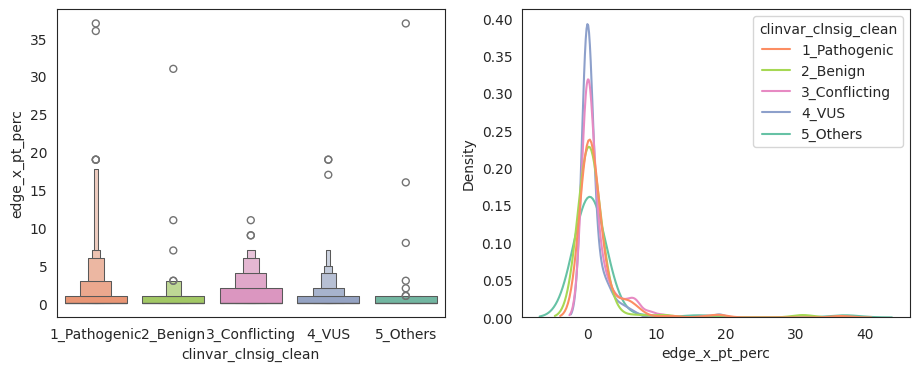

In [18]:
fig, ax = plt.subplots(1,2, figsize=(11,4))
sns.boxenplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
                 x="clinvar_clnsig_clean", y="edge_x_pt_perc", ax=ax[0],#hue="clinvar_clnsig_clean",
                 palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

sns.kdeplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
                 x="edge_x_pt_perc", hue="clinvar_clnsig_clean", common_norm=False, ax=ax[1], 
                 palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]
# sns.displot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="edge_x_pt_perc", hue="clinvar_clnsig_clean", col="clinvar_clnsig_clean", kind="hist", common_norm=False, #ax=ax, 
#                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

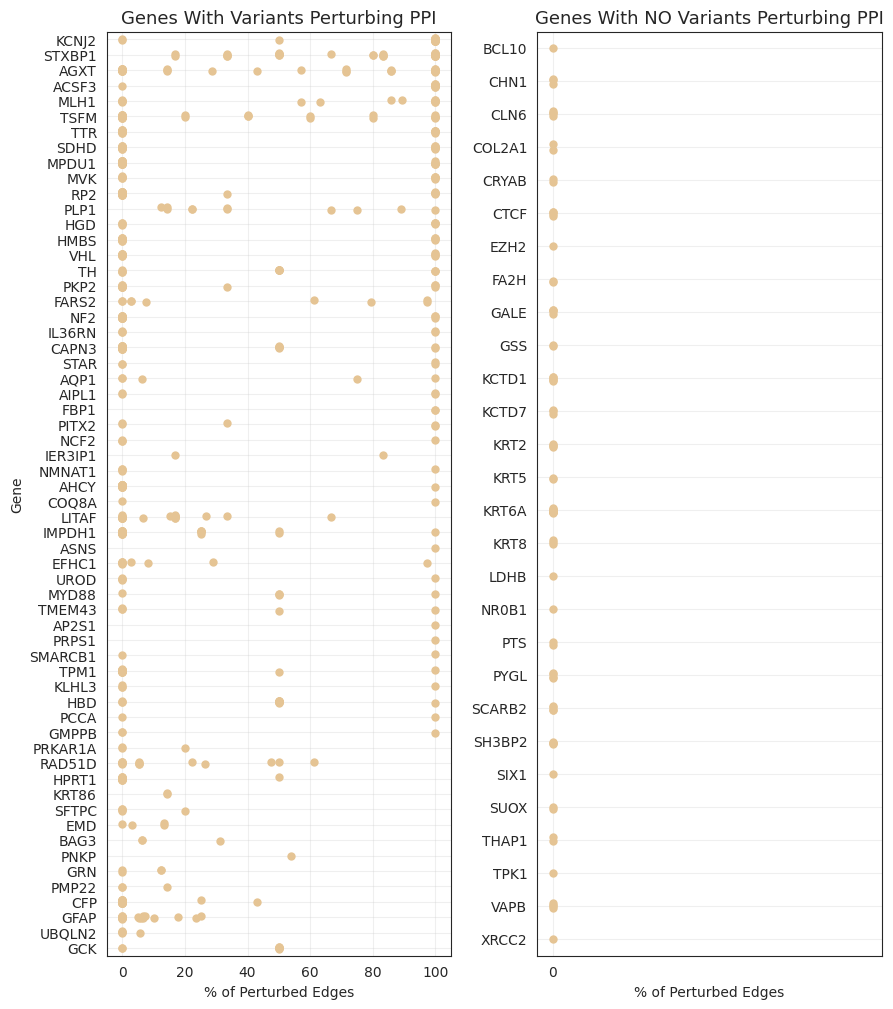

In [46]:
fig, ax = plt.subplots(1,2, figsize=(10,12))
gene_ppi_sum_df = variant_ppi_perturb_stats_clinvar.with_columns(
    (pl.col("perturbed_percentage")>thres_llr).alias("pert_perc_geq75")
).group_by(
    "symbol"
).agg(
    pl.col("pert_perc_geq75").sum().alias("pert_perc_geq75_sum"),
    pl.col("perturbed_percentage").max().alias("pert_perc_geq75_max")
)

hits_gene_order = gene_ppi_sum_df.filter(
   (pl.col("symbol").is_not_null()) & (pl.col("pert_perc_geq75_max")>0)
).sort("pert_perc_geq75_sum", descending=True)['symbol']

no_hits_gene_order = gene_ppi_sum_df.filter(
   (pl.col("symbol").is_not_null()) & (pl.col("pert_perc_geq75_max")==0)
).sort("symbol", descending=False)['symbol']

sns.stripplot(data=variant_ppi_perturb_stats_clinvar.filter(
                (pl.col("symbol").is_in(hits_gene_order)) & (pl.col("symbol").is_not_null())
              ).to_pandas().sort_values(by="clinvar_clnsig_clean"), color=sns.color_palette("Set2")[-2],
              size=6,
              y="symbol", x="perturbed_percentage", ax=ax[0],#hue="clinvar_clnsig_clean", 
              order=hits_gene_order) # hue_order=["perturbed","not perturbed","inconclusive"], palette=palette_dict["clinvar_clnsig_clean"]
sns.stripplot(data=variant_ppi_perturb_stats_clinvar.filter(
                (pl.col("symbol").is_in(no_hits_gene_order)) & (pl.col("symbol").is_not_null())
              ).to_pandas().sort_values(by="clinvar_clnsig_clean"), color=sns.color_palette("Set2")[-2],size=6,
              y="symbol", x="perturbed_percentage", ax=ax[1],#hue="clinvar_clnsig_clean", 
              order=no_hits_gene_order) # hue_order=["perturbed","not perturbed","inconclusive"], palette=palette_dict["clinvar_clnsig_clean"]
ax[0].set_ylabel("Gene")
ax[1].set_ylabel("")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax[1].set_xlabel("% of Perturbed Edges")
ax[0].set_xlabel("% of Perturbed Edges")
ax[1].set_title("Genes With NO Variants Perturbing PPI", fontsize=13)
ax[0].set_title("Genes With Variants Perturbing PPI", fontsize=13)
ax[1].set_xlim(ax[0].get_xlim())  # or just [0] if that's all you need

ax[1].set_xticks([0])  # or just [0] if that's all you need
ax[0].grid(alpha=.3)
ax[1].grid(alpha=.3)
plt.subplots_adjust(wspace=.25)
# ax.legend(loc="upper right")
# ax.axhline(75, color="tomato", linestyle="--")

# sns.kdeplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="edge_x_pt_perc", hue="clinvar_clnsig_clean", common_norm=False, ax=ax[1], 
#                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

# sns.displot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="edge_x_pt_perc", hue="clinvar_clnsig_clean", col="clinvar_clnsig_clean", kind="hist", common_norm=False, #ax=ax, 
#                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

In [119]:


var_ppi_perturb_by_gene_cv = variant_ppi_perturb_stats_clinvar.filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign"])
).group_by(
    ["symbol","clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)
var_ppi_perturb_by_gene_cv_hits = variant_ppi_perturb_stats_clinvar.filter(
    (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign"])) & ((pl.col("perturbed_percentage")>threshold).alias(f"pert_perc_geq{threshold}"))
).group_by(
    ["symbol","clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)

var_ppi_perturb_by_gene_cv_hits = var_ppi_perturb_by_gene_cv.join(
    var_ppi_perturb_by_gene_cv_hits,
    on=["symbol","clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)
# .pivot(
#     values=["total_counts", "hit_counts", "hit_perc"],        # what you want in the cells
#     index="symbol",                               # one row per gene
#     columns="clinvar_clnsig_clean",               # makes the new headers
# ).fill_null(0)
var_ppi_perturb_by_gene_cv_hits

symbol,clinvar_clnsig_clean,total_counts,hit_counts,hit_perc
str,str,u32,u32,f64
"""XRCC2""","""2_Benign""",1,0,0.0
"""KCNJ2""","""1_Pathogenic""",13,12,92.307692
"""HPRT1""","""1_Pathogenic""",12,0,0.0
"""GMPPB""","""1_Pathogenic""",3,1,33.333333
"""FARS2""","""2_Benign""",2,1,50.0
…,…,…,…,…
"""TSFM""","""2_Benign""",4,0,0.0
"""MVK""","""2_Benign""",1,0,0.0
"""SUOX""","""1_Pathogenic""",1,0,0.0


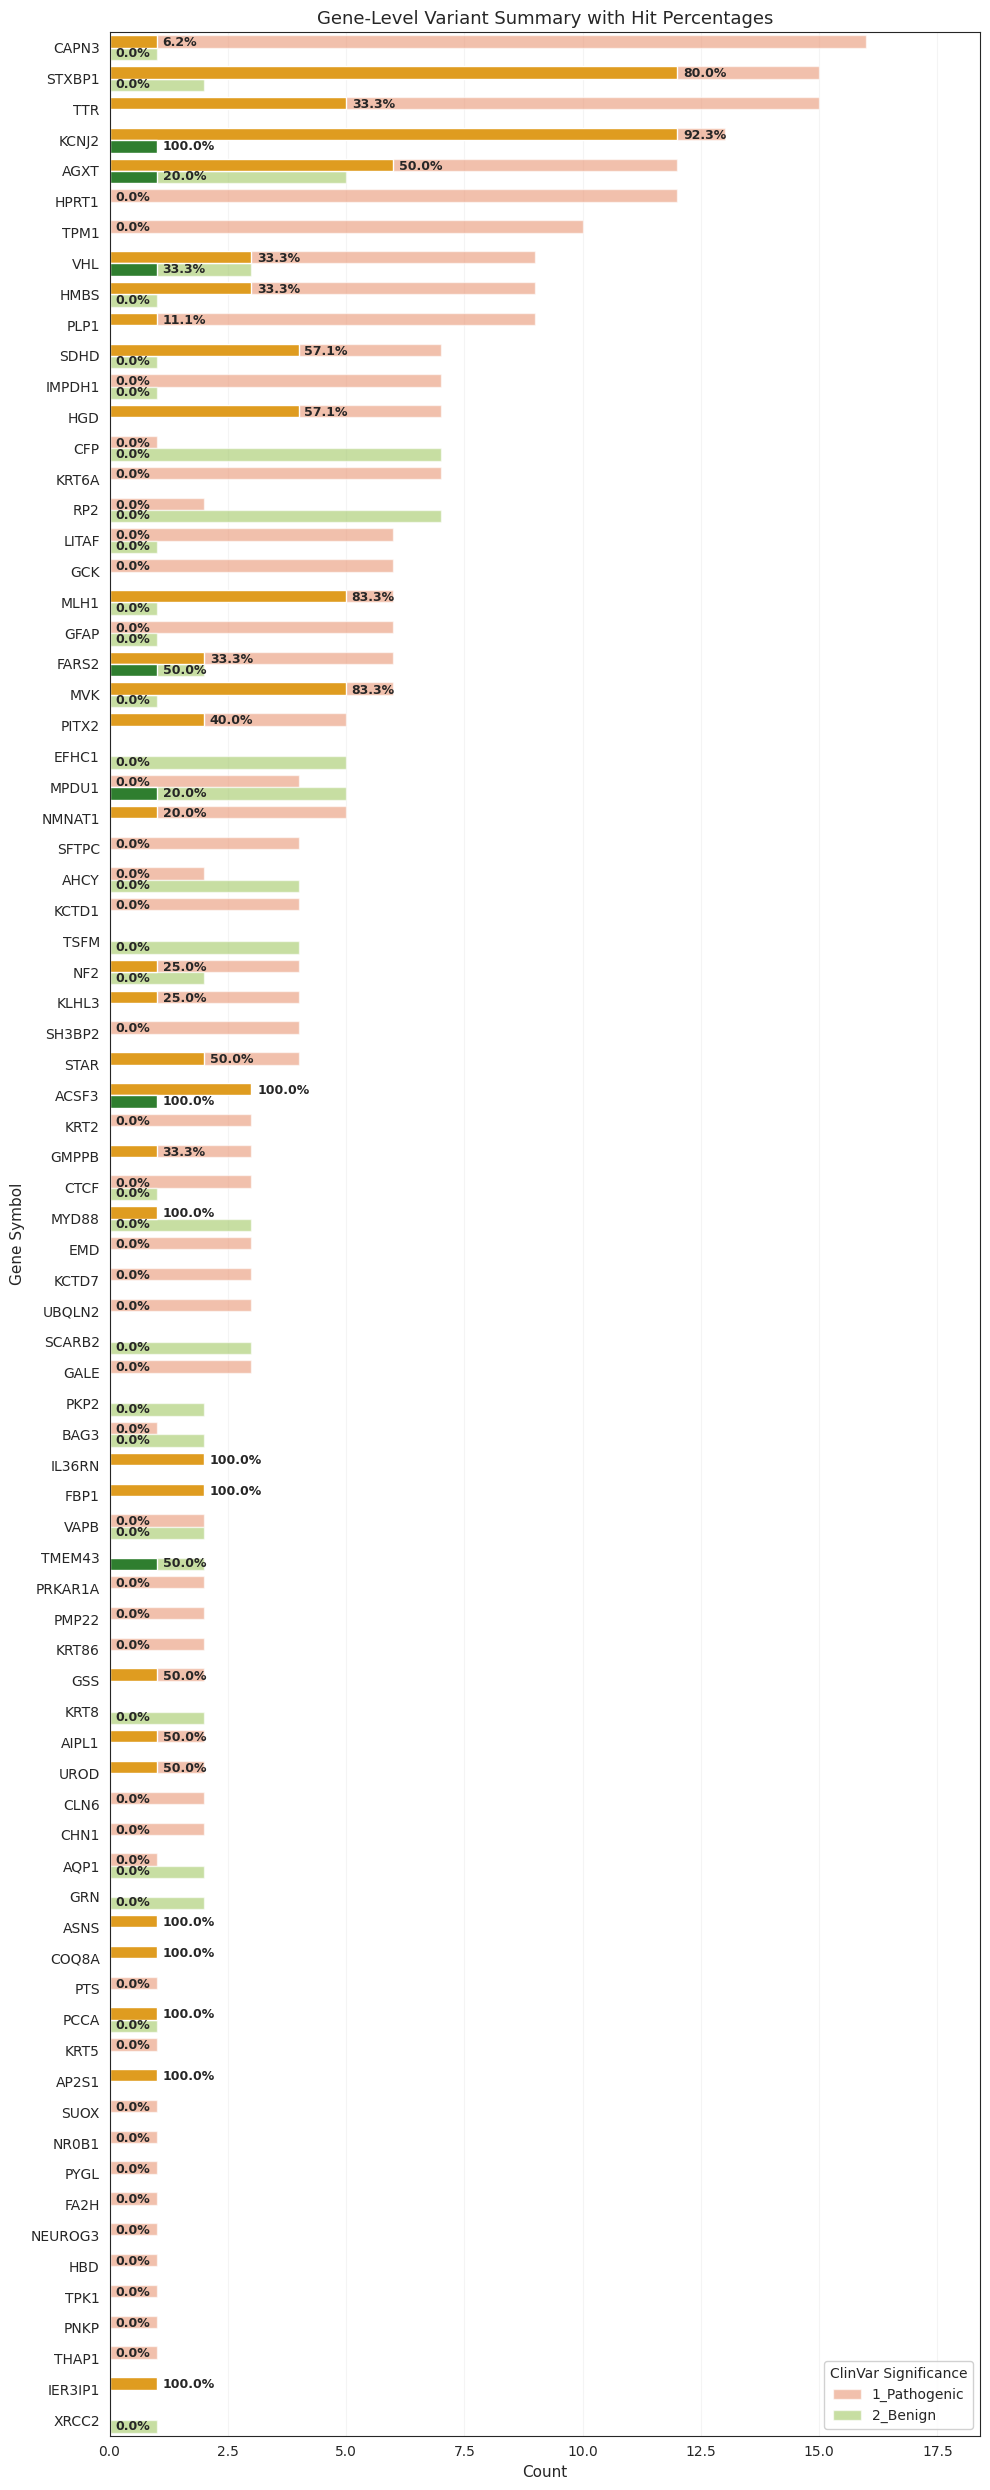

,symbol,clinvar_clnsig_clean,total_counts,hit_counts,hit_perc
0,CAPN3,1_Pathogenic,16,1,6.250000
1,STXBP1,1_Pathogenic,15,12,80.000000
2,TTR,1_Pathogenic,15,5,33.333333
3,KCNJ2,1_Pathogenic,13,12,92.307692
4,AGXT,1_Pathogenic,12,6,50.000000
...,...,...,...,...,...
98,IER3IP1,1_Pathogenic,1,1,100.000000
99,CAPN3,2_Benign,1,0,0.000000
100,KCNJ2,2_Benign,1,1,100.000000
101,IMPDH1,2_Benign,1,0,0.000000


In [120]:
def plot_gene_level_summary(total_allele_hit_sum_df):
    # Convert to pandas and sort
    total_allele_hit_sum_df = total_allele_hit_sum_df.to_pandas().sort_values(
        by=["total_counts"], ascending=False
    ).reset_index(drop=True)
    
    n_genes = len(total_allele_hit_sum_df)
    
    # Dynamically scale figure size
    fig_height = max(6, min(n_genes * 0.3, 25))
    fig_width = 10  # Slightly wider to accommodate labels
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Create the barplots
    # Total counts (background bars)
    sns.barplot(
        data=total_allele_hit_sum_df, 
        y="symbol", 
        x="total_counts", 
        hue="clinvar_clnsig_clean", 
        palette=palette_dict["clinvar_clnsig_clean"],
        alpha=0.6,  # Make background bars slightly transparent
        ax=ax
    )
    
    # Hit counts (foreground bars)
    sns.barplot(
        data=total_allele_hit_sum_df, 
        y="symbol", 
        x="hit_counts", 
        hue="clinvar_clnsig_clean", 
        palette=["orange","forestgreen"],
        ax=ax
    )
    
    # Add percentage labels
    # Get unique categories and their positions
    categories = total_allele_hit_sum_df["clinvar_clnsig_clean"].unique()
    n_categories = len(categories)
    
    # Calculate bar positions for each category
    bar_height = 0.7 / n_categories  # Default seaborn bar height divided by number of categories
    
    for i, gene in enumerate(total_allele_hit_sum_df["symbol"].unique()):
        gene_data = total_allele_hit_sum_df[total_allele_hit_sum_df["symbol"] == gene]
        
        for j, category in enumerate(categories):
            cat_data = gene_data[gene_data["clinvar_clnsig_clean"] == category]
            
            if not cat_data.empty:
                # Calculate bar position
                bar_center = i + (j - (n_categories - 1) / 2) * bar_height
                
                # Get the hit percentage value
                hit_perc = cat_data["hit_perc"].iloc[0]
                hit_counts = cat_data["hit_counts"].iloc[0]
                
                # Add percentage label at the end of the hit_counts bar
                ax.text(
                    hit_counts + max(total_allele_hit_sum_df["hit_counts"]) * 0.01,  # Small offset
                    bar_center+.02,
                    f"{hit_perc:.1f}%",
                    ha="left",
                    va="center",
                    fontsize=9 if n_genes > 20 else 10,
                    fontweight="bold"
                )
    
    # Formatting
    ax.grid(alpha=0.2, axis='x')
    ax.set_xlabel("Count", fontsize=11)
    ax.set_ylabel("Gene Symbol", fontsize=11)
    ax.set_title("Gene-Level Variant Summary with Hit Percentages", fontsize=13)
    
    # Adjust x-axis limit to accommodate labels
    max_count = max(total_allele_hit_sum_df["total_counts"].max(), 
                    total_allele_hit_sum_df["hit_counts"].max())
    ax.set_xlim(0, max_count * 1.15)
    
    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    # Remove duplicate legend entries (seaborn creates duplicates with multiple barplots)
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    
    ax.legend(unique_handles, unique_labels, 
              title="ClinVar Significance", 
              fontsize=10, 
              loc="lower right",
              framealpha=0.9)
    
    plt.tight_layout()
    plt.show()
    
    return total_allele_hit_sum_df

plot_gene_level_summary(var_ppi_perturb_by_gene_cv_hits)

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
gene_ppi_sum_df = variant_ppi_perturb_stats_clinvar.with_columns(
    (pl.col("perturbed_percentage")>75).alias("pert_perc_geq75")
).group_by(
    "symbol"
).agg(
    pl.col("pert_perc_geq75").sum().alias("pert_perc_geq75_sum"),
    pl.col("perturbed_percentage").max().alias("pert_perc_geq75_max")
)

hits_gene_order = gene_ppi_sum_df.filter(
   (pl.col("symbol").is_not_null()) & (pl.col("pert_perc_geq75_max")>0)
).sort("pert_perc_geq75_sum", descending=True)['symbol']

no_hits_gene_order = gene_ppi_sum_df.filter(
   (pl.col("symbol").is_not_null()) & (pl.col("pert_perc_geq75_max")==0)
).sort("symbol", descending=False)['symbol']

sns.stripplot(data=variant_ppi_perturb_stats_clinvar.filter(
                (pl.col("symbol").is_in(hits_gene_order)) & (pl.col("symbol").is_not_null())
              ).to_pandas().sort_values(by="clinvar_clnsig_clean"), color=sns.color_palette("Set2")[-2],
              size=6,
              y="symbol", x="perturbed_percentage", ax=ax[0],#hue="clinvar_clnsig_clean", 
              order=hits_gene_order) # hue_order=["perturbed","not perturbed","inconclusive"], palette=palette_dict["clinvar_clnsig_clean"]
sns.stripplot(data=variant_ppi_perturb_stats_clinvar.filter(
                (pl.col("symbol").is_in(no_hits_gene_order)) & (pl.col("symbol").is_not_null())
              ).to_pandas().sort_values(by="clinvar_clnsig_clean"), color=sns.color_palette("Set2")[-2],size=6,
              y="symbol", x="perturbed_percentage", ax=ax[1],#hue="clinvar_clnsig_clean", 
              order=no_hits_gene_order) # hue_order=["perturbed","not perturbed","inconclusive"], palette=palette_dict["clinvar_clnsig_clean"]
ax[0].set_ylabel("Gene")
ax[1].set_ylabel("")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax[1].set_xlabel("% of Perturbed Edges")
ax[0].set_xlabel("% of Perturbed Edges")
ax[1].set_title("Genes With NO Variants Perturbing PPI", fontsize=13)
ax[0].set_title("Genes With Variants Perturbing PPI", fontsize=13)
ax[1].set_xlim(ax[0].get_xlim())  # or just [0] if that's all you need

ax[1].set_xticks([0])  # or just [0] if that's all you need
ax[0].grid(alpha=.3)
ax[1].grid(alpha=.3)
plt.subplots_adjust(wspace=.25)
# ax.legend(loc="upper right")
# ax.axhline(75, color="tomato", linestyle="--")

# sns.kdeplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="edge_x_pt_perc", hue="clinvar_clnsig_clean", common_norm=False, ax=ax[1], 
#                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

# sns.displot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="edge_x_pt_perc", hue="clinvar_clnsig_clean", col="clinvar_clnsig_clean", kind="hist", common_norm=False, #ax=ax, 
#                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

In [35]:
variant_ppi_perturb_stats_clinvar_gene = variant_ppi_perturb_stats_clinvar.group_by("symbol","clinvar_clnsig_clean").agg(
    pl.col("perturbed_percentage").mean().alias("perturb_perc_mean"),
    pl.col("perturbed_percentage").median().alias("perturb_perc_median")
)

<Figure size 640x480 with 0 Axes>

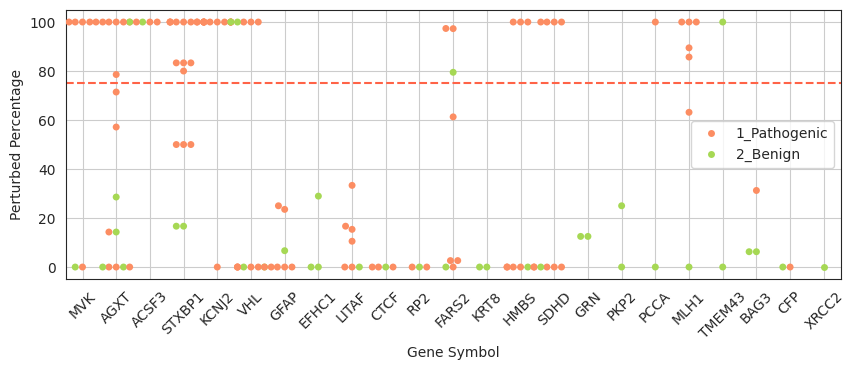

In [36]:
plt.clf()
hue_order = sorted(variant_ppi_perturb_stats_clinvar.drop_nulls("clinvar_clnsig_clean")["clinvar_clnsig_clean"].unique())[:2]
benign_gene = variant_ppi_perturb_stats_clinvar.filter(pl.col("clinvar_clnsig_clean")=="2_Benign")["symbol"].unique()
fig, ax = plt.subplots(1,1,figsize=(10, 3.5))
sns.swarmplot(data=variant_ppi_perturb_stats_clinvar.filter(
    pl.col("symbol").is_in(benign_gene),
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic", "2_Benign"]),
).select(
    pl.col(["perturbed_percentage","symbol","clinvar_clnsig_clean"])
).to_pandas(),
    y="perturbed_percentage", 
    x="symbol", 
    hue="clinvar_clnsig_clean",
    palette=palette_dict["clinvar_clnsig_clean"],
    # dodge=True,
    hue_order=hue_order,
    # gap=.25,
    # flier_kws=dict(facecolor=".2", linewidth=.5, marker="^"),
    ax=ax)
# sns.boxenplot(data=variant_ppi_perturb_stats_clinvar.filter(
#     pl.col("symbol").is_in(benign_gene),
#     pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic", "2_Benign"]),
# ).select(
#     pl.col(["perturbed_percentage","symbol","clinvar_clnsig_clean"])
# ).to_pandas(),
#     y="perturbed_percentage", 
#     x="symbol", 
#     hue="clinvar_clnsig_clean",
#     palette=palette_dict["clinvar_clnsig_clean"],
#     # dodge=True,
#     hue_order=hue_order,
#     # gap=.25,
#     # flier_kws=dict(facecolor=".2", linewidth=.5, marker="^"),
#     ax=ax)
ax.set_xlabel("Gene Symbol")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Perturbed Percentage")
ax.legend(loc="center right", frameon=True)
ax.axhline(75, color="tomato", linestyle="--")
ax.grid()

# plt.clf()
# hue_order = sorted(variant_ppi_perturb_stats_clinvar.drop_nulls("clinvar_clnsig_clean")["clinvar_clnsig_clean"].unique())
# fig, ax = plt.subplots(1,1,figsize=(10, 20))
# sns.boxenplot(data=variant_ppi_perturb_stats_clinvar.select(
#                 pl.col(["perturbed_percentage","symbol","clinvar_clnsig_clean"])
#             ).to_pandas(),
#             x="perturbed_percentage", 
#             y="symbol", 
#             hue="clinvar_clnsig_clean",
#             palette=palette_dict["clinvar_clnsig_clean"],
#             dodge=True,
#             hue_order=hue_order,
#             ax=ax)
# ax.set_xlabel("perturbed_percentage")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# ax.set_ylabel("Gene Symbol")
# ax.grid()

<Figure size 640x480 with 0 Axes>

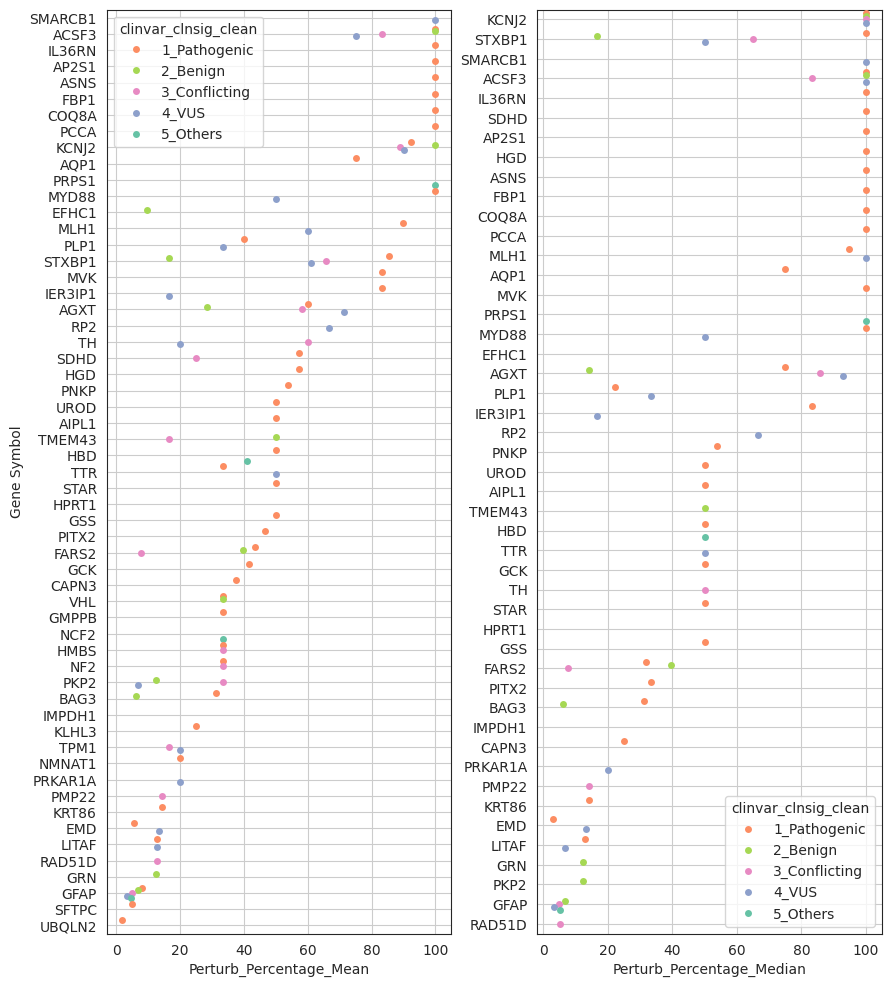

In [37]:
plt.clf()
hue_order = sorted(variant_ppi_perturb_stats_clinvar_gene.drop_nulls("clinvar_clnsig_clean")["clinvar_clnsig_clean"].unique())
fig, ax = plt.subplots(1,2,figsize=(10, 12))
sns.swarmplot(data=variant_ppi_perturb_stats_clinvar_gene.filter(pl.col("perturb_perc_mean")>0).sort("perturb_perc_mean", descending=True).select(
                pl.col(["perturb_perc_mean","symbol","clinvar_clnsig_clean"])
            ).to_pandas(),
            x="perturb_perc_mean", 
            y="symbol", 
            hue="clinvar_clnsig_clean",
            palette=palette_dict["clinvar_clnsig_clean"],
            dodge=True,
            hue_order=hue_order,
            ax=ax[0])
ax[0].set_xlabel("Perturb_Percentage_Mean")
ax[0].set_ylabel("Gene Symbol")
ax[0].grid()

sns.swarmplot(data=variant_ppi_perturb_stats_clinvar_gene.filter(pl.col("perturb_perc_median")>0).sort("perturb_perc_median", descending=True).select(
                pl.col(["perturb_perc_median","symbol","clinvar_clnsig_clean"])
            ).to_pandas(),
            x="perturb_perc_median", 
            y="symbol", 
            hue="clinvar_clnsig_clean",
            dodge=True,
            palette=palette_dict["clinvar_clnsig_clean"],
            hue_order=hue_order,
            ax=ax[1])
ax[1].set_xlabel("Perturb_Percentage_Median")
ax[1].set_ylabel("")
ax[1].grid()
plt.subplots_adjust(wspace=0.25)
plt.show()

## 3. Map with Pillar Data

In [121]:
variant_ppi_perturb_stats_clinvar_pillar = variant_ppi_perturb_stats_clinvar.filter(pl.col("pillar_tested"))
variant_ppi_perturb_stats_clinvar_gene_pillar = variant_ppi_perturb_stats_clinvar_pillar.group_by("symbol","clinvar_clnsig_clean").agg(
    pl.col("perturbed_percentage").mean().alias("perturb_perc_mean"),
    pl.col("perturbed_percentage").median().alias("perturb_perc_median")
)
variant_ppi_perturb_stats_clinvar_gene_pillar

symbol,clinvar_clnsig_clean,perturb_perc_mean,perturb_perc_median
str,str,f64,f64
"""GCK""",null,0.0,0.0
"""CTCF""","""1_Pathogenic""",0.0,0.0
"""HMBS""","""3_Conflicting""",33.333333,0.0
"""HMBS""","""1_Pathogenic""",33.333333,0.0
"""HMBS""","""2_Benign""",0.0,0.0
"""GCK""","""1_Pathogenic""",50.0,50.0
"""RAD51D""","""3_Conflicting""",15.204,5.26
"""HMBS""","""4_VUS""",0.0,0.0


In [122]:
variant_ppi_perturb_stats_clinvar_pillar#.unique("symbol")

gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,no_perturbed_percentage,no_perturbed_count,edge_x_pt_perc,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,…,clinvar_star,auth_reported_rep_score,Mode of Inheritance_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,aa_change_pp,Evidence Repo Link_ClinGen_repo,Interval 2 name,Interval 6 range,Interval 1 range,Rationale_presumed_PMID:34273903,aa_alt,clinvar_date_last_reviewed,auth_transcript_id,Interval 2 range,Naive_prior_prob_PMID:31131967,Approval Date_ClinGen_repo,simplified_consequence,Expert Panel_ClinGen_repo,aa_pos,transcript_ref,Disease_ClinGen_repo,gnomad_MAF,auth_reported_score,Interval 1 MaveDB class,clinvar_sig,hg38_start,consequence,Interval 5 MaveDB class,REVEL,auth_reported_func_class,Interval 3 name,Family History LR_PMID:31131967,PubMed Articles_ClinGen_repo,Assay_type,Interval 4 range,Calcualted_post_prob_PMID:31131967,gene_variant_pp
str,u32,u32,u32,u32,f64,f64,f64,f64,u32,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,f64,str,str,f64,f64,str,str,f64,str,str,f64,str,str,f64,str,str,str,f64,str
"""HMBS_Arg195Cys""",1,1,0,0,100.0,0.0,0.0,100.0,1,0.0,true,"""HMBS""","""ENSG00000256269""",2803,200936,"""CCSBVarC005168""","""ALE00005168""","""NC_000011.10:119091497:C:T""","""583C>T""","""Arg195Cys""","""CEGS2""","""CegsMutGDEh1045""","""E06""","""GDEhDisVCh_40054""","""E08""","""2""","""CegsMutGDDh1045""","""E06""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,…,"""criteria provided, single subm…",null,null,null,"""Arg195Cys""",null,null,null,null,null,"""C""","""Feb 03, 2023""",null,null,null,null,"""missense_variant""",null,195.0,null,null,0.000005,0.53699,null,"""Pathogenic""",1.19091497e8,"""missense_variant""",null,0.903,null,null,null,null,"""Cell viability""",null,null,"""HMBS_Arg195Cys"""
"""HMBS_Arg321His""",1,0,0,1,0.0,0.0,100.0,0.0,0,1.0,true,"""HMBS""","""ENSG00000256269""",2803,200946,"""CCSBVarC005178""","""ALE00005178""","""NC_000011.10:119093159:G:A""","""962G>A""","""Arg321His""","""CEGS2""","""CegsMutGDEh1045""","""A10""","""GDEhDisVCh_40054""","""B09""","""2""","""CegsMutGDDh1045""","""A10""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,…,"""criteria provided, conflicting…",null,null,null,"""Arg321His""",null,null,null,null,null,"""H""","""Jan 31, 2024""",null,null,null,null,"""missense_variant""",null,321.0,null,null,0.00126,0.863077,null,"""Conflicting classifications of…",1.19093159e8,"""missense_variant""",null,0.563,null,null,null,null,null,null,null,"""HMBS_Arg321His"""
"""RAD51D_Val66Leu""",19,16,2,1,84.21,10.53,5.26,94.74,18,0.9994,true,"""RAD51D""",null,7201,null,"""CCSBVarC024807""",null,"""NC_000017.11:35118568:C:A""",null,"""Val66Leu""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,"""criteria provided, conflicting…",null,null,null,"""Val66Leu""",null,null,null,null,null,"""L""","""Aug 10, 2023""",null,null,null,null,"""missense_variant""",null,66.0,"""G""",null,0.000001,0.0187496,null,"""Conflicting classifications of…",3.5118568e7,"""missense_variant""",null,0.048,"""functionally_normal""",null,null,null,"""Cell viability""",null,null,"""RAD51D_Val66Leu"""
"""RAD51D_Val56Gly""",19,15,4,0,78.95,21.05,0.0,100.0,19,0.0,true,"""RAD51D""",null,7201,null,"""CCSBVarC024801""",null,"""NC_000017.11:35118597:A:C""",null,"""Val56Gly""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,"""crit

In [124]:
variant_ppi_perturb_stats_clinvar_pillar.filter(pl.col("symbol")=="HMBS").sort("perturbed_percentage", descending=True)

gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,no_perturbed_percentage,no_perturbed_count,edge_x_pt_perc,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,…,clinvar_star,auth_reported_rep_score,Mode of Inheritance_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,aa_change_pp,Evidence Repo Link_ClinGen_repo,Interval 2 name,Interval 6 range,Interval 1 range,Rationale_presumed_PMID:34273903,aa_alt,clinvar_date_last_reviewed,auth_transcript_id,Interval 2 range,Naive_prior_prob_PMID:31131967,Approval Date_ClinGen_repo,simplified_consequence,Expert Panel_ClinGen_repo,aa_pos,transcript_ref,Disease_ClinGen_repo,gnomad_MAF,auth_reported_score,Interval 1 MaveDB class,clinvar_sig,hg38_start,consequence,Interval 5 MaveDB class,REVEL,auth_reported_func_class,Interval 3 name,Family History LR_PMID:31131967,PubMed Articles_ClinGen_repo,Assay_type,Interval 4 range,Calcualted_post_prob_PMID:31131967,gene_variant_pp
str,u32,u32,u32,u32,f64,f64,f64,f64,u32,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,f64,str,str,f64,f64,str,str,f64,str,str,f64,str,str,f64,str,str,str,f64,str
"""HMBS_Arg321His""",1,0,0,1,0.0,0.0,100.0,0.0,0,1.0,true,"""HMBS""","""ENSG00000256269""",2803,200946,"""CCSBVarC005178""","""ALE00005178""","""NC_000011.10:119093159:G:A""","""962G>A""","""Arg321His""","""CEGS2""","""CegsMutGDEh1045""","""A10""","""GDEhDisVCh_40054""","""B09""","""2""","""CegsMutGDDh1045""","""A10""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,…,"""criteria provided, conflicting…",null,null,null,"""Arg321His""",null,null,null,null,null,"""H""","""Jan 31, 2024""",null,null,null,null,"""missense_variant""",null,321.0,null,null,0.00126,0.863077,null,"""Conflicting classifications of…",1.19093159e8,"""missense_variant""",null,0.563,null,null,null,null,null,null,null,"""HMBS_Arg321His"""
"""HMBS_Glu250Lys""",1,0,0,1,0.0,0.0,100.0,0.0,0,1.0,true,"""HMBS""","""ENSG00000256269""",2803,200945,"""CCSBVarC005174""","""ALE00005174""","""NC_000011.10:119092500:G:A""","""748G>A""","""Glu250Lys""","""CEGS2""","""CegsMutGDEh1041""","""D10""","""GDEhDisVCh_40054""","""H06""","""2""","""CegsMutGDDh1041""","""D10""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,…,"""no assertion criteria provided""",null,null,null,"""Glu250Lys""",null,null,null,null,null,"""K""","""Jan 01, 1994""",null,null,null,null,"""missense_variant""",null,250.0,null,null,null,0.018139,null,"""Pathogenic""",1.190925e8,"""missense_variant""",null,0.964,null,null,null,null,null,null,null,"""HMBS_Glu250Lys"""
"""HMBS_Cys247Arg""",1,0,0,1,0.0,0.0,100.0,0.0,0,1.0,true,"""HMBS""","""ENSG00000256269""",2803,200941,"""CCSBVarC005173""","""ALE00005173""","""NC_000011.10:119092491:T:C""","""739T>C""","""Cys247Arg""","""CEGS2""","""CegsMutGDEh1038""","""E07""","""GDEhDisVCh_40054""","""A04""","""2""","""CegsMutGDDh1038""","""E07""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,…,"""criteria provided, single subm…",null,null,null,"""Cys247Arg""",null,null,null,null,null,"""R""","""Apr 27, 2022""",null,null,null,null,"""missense_variant""",null,247.0,null,null,null,-0.126983,null,"""Likely pathogenic""",1.19092491e8,"""missense_variant""",null,0.981,null,null,null,null,"""Cell viability""",null,null,"""HMBS_Cys247Arg"""
"""HMBS_Ala252Val""",1,0,0,1,0.0,0.0,100.0,0.0,0,1.0,true,"""HMBS""","""ENSG00000256269""",2803,200942,"""CCSBVarC005176""","""ALE00005176""","""NC_000011.10:119092507:C:T""","""755C>T""

<Figure size 640x480 with 0 Axes>

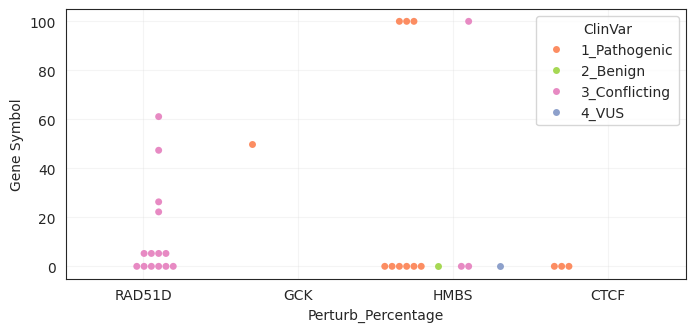

In [41]:
plt.clf()
hue_order = sorted(variant_ppi_perturb_stats_clinvar_pillar.drop_nulls("clinvar_clnsig_clean")["clinvar_clnsig_clean"].unique())
fig, ax = plt.subplots(1,1,figsize=(8, 3.5))
sns.swarmplot(data=variant_ppi_perturb_stats_clinvar_pillar.select(
                pl.col(["perturbed_percentage","symbol","clinvar_clnsig_clean"])
            ).to_pandas(),
            y="perturbed_percentage", 
            x="symbol", 
            hue="clinvar_clnsig_clean",
            palette=palette_dict["clinvar_clnsig_clean"],
            dodge=True,
            hue_order=hue_order,
            ax=ax)
ax.set_xlabel("Perturb_Percentage")
ax.set_ylabel("Gene Symbol")
ax.grid(alpha=.2)
ax.legend(frameon=True, title="ClinVar")

# sns.swarmplot(data=variant_ppi_perturb_stats_clinvar_pillar.select(
#                 pl.col(["perturbed_percentage","symbol","clinvar_clnsig_clean"])
#             ).to_pandas(),
#             x="perturbed_percentage", 
#             y="symbol", 
#             hue="clinvar_clnsig_clean",
#             dodge=True,
#             palette=palette_dict["clinvar_clnsig_clean"],
#             hue_order=hue_order,
#             ax=ax[1])
# ax[1].set_xlabel("Perturb_Percentage")
# ax[1].set_ylabel("")
# ax[1].grid()
# plt.subplots_adjust(wspace=0.25)
plt.show()

gene_variant,clinvar_sig,Interval 1 name,Interval 1 MaveDB class,perturbed_percentage
str,str,str,str,f64
"""RAD51D_Ala231Ser""","""Conflicting classifications of…",null,null,0.0
"""RAD51D_Val56Gly""","""Conflicting classifications of…",null,null,0.0
"""RAD51D_Met308Val""","""Conflicting classifications of…",null,null,0.0
"""RAD51D_Ile251Val""","""Conflicting classifications of…",null,null,0.0
"""RAD51D_Glu307Lys""","""Conflicting classifications of…",null,null,26.32
"""RAD51D_Val66Leu""","""Conflicting classifications of…",null,null,5.26
"""RAD51D_His23Arg""","""Conflicting classifications of…",null,null,5.26
"""RAD51D_Val66Met""","""Conflicting classifications of…",null,null,5.26
"""RAD51D_Cys9Ser""","""Conflicting classifications of…",null,null,22.22


gene_variant,clinvar_sig,Interval 2 name,Interval 2 MaveDB class,perturbed_percentage
str,str,str,str,f64
"""RAD51D_Ala231Ser""","""Conflicting classifications of…",null,null,0.0
"""RAD51D_Val56Gly""","""Conflicting classifications of…",null,null,0.0
"""RAD51D_Met308Val""","""Conflicting classifications of…",null,null,0.0
"""RAD51D_Ile251Val""","""Conflicting classifications of…",null,null,0.0
"""RAD51D_Glu307Lys""","""Conflicting classifications of…",null,null,26.32
"""RAD51D_Val66Leu""","""Conflicting classifications of…",null,null,5.26
"""RAD51D_His23Arg""","""Conflicting classifications of…",null,null,5.26
"""RAD51D_Val66Met""","""Conflicting classifications of…",null,null,5.26
"""RAD51D_Cys9Ser""","""Conflicting classifications of…",null,null,22.22


gene_variant,clinvar_sig,Interval 3 name,Interval 3 MaveDB class,perturbed_percentage
str,str,str,str,f64
"""RAD51D_Ala231Ser""","""Conflicting classifications of…",null,null,0.0
"""RAD51D_Val56Gly""","""Conflicting classifications of…",null,null,0.0
"""RAD51D_Met308Val""","""Conflicting classifications of…",null,null,0.0
"""RAD51D_Ile251Val""","""Conflicting classifications of…",null,null,0.0
"""RAD51D_Glu307Lys""","""Conflicting classifications of…",null,null,26.32
"""RAD51D_Val66Leu""","""Conflicting classifications of…",null,null,5.26
"""RAD51D_His23Arg""","""Conflicting classifications of…",null,null,5.26
"""RAD51D_Val66Met""","""Conflicting classifications of…",null,null,5.26
"""RAD51D_Cys9Ser""","""Conflicting classifications of…",null,null,22.22


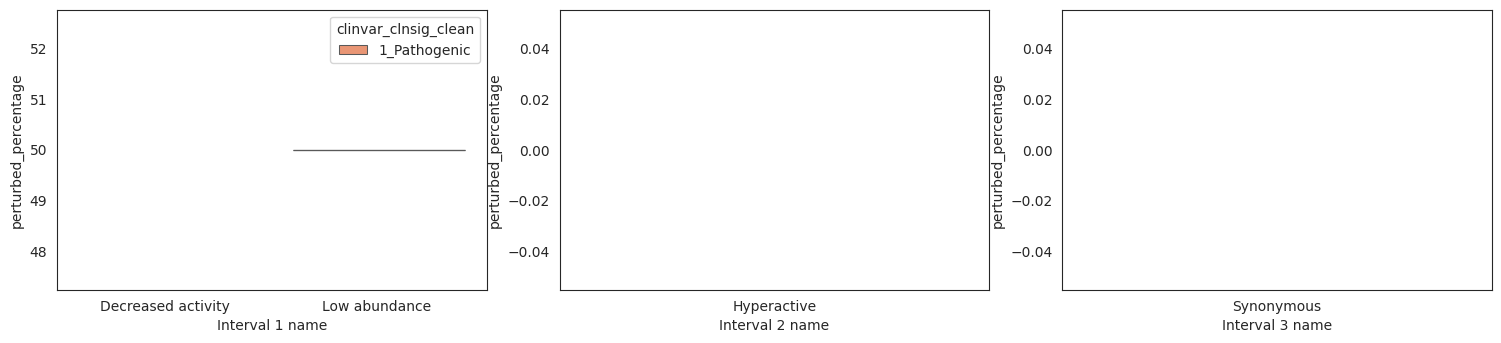

In [43]:
func_scores = variant_ppi_perturb_stats_clinvar.filter(pl.col("pillar_tested"))
pl.Config.set_tbl_rows(25)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

fig, axes = plt.subplots(2, 4, figsize=(25,8))
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_mave = func_scores.drop_nulls(pl.col(mavedb_name))
    if func_mave.shape[0] > 0:
        display(func_scores.filter(pl.col("gene_variant").str.contains("RAD51D"))["gene_variant","clinvar_sig",int_name, mavedb_name,"perturbed_percentage"])
        # fig, ax = plt.subplots(1,2,figsize=(15,6))
        hue_order = sorted(func_mave.drop_nulls("clinvar_clnsig_clean").unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
        sns.boxenplot(
            data=func_mave.unique(subset="gene_variant").to_pandas(),
            x=int_name,
            y="perturbed_percentage",
            ax=axes.flatten()[i-1],
            palette=palette_dict["clinvar_clnsig_clean"], 
            hue="clinvar_clnsig_clean", 
            hue_order=hue_order,
            dodge=True,
        )
        # sns.boxenplot(
        #     data=func_mave.unique(subset="gene_variant").to_pandas(),
        #     x=mavedb_name,
        #     y="zscore_log2",
        #     ax=ax[1],
        #     palette=palette_dict["clinvar_clnsig_clean"],
        #     hue="clinvar_clnsig_clean", 
        #     hue_order=hue_order,
        #     dodge=True
        # )
    else:
        fig.delaxes(axes.flatten()[i-1])

fig.delaxes(axes.flatten()[6])
fig.delaxes(axes.flatten()[7])
plt.subplots_adjust(wspace=0.17)
plt.show()